# User data 입력

In [1]:
print("<나와 잘 맞는 최고의 교수자는?>")
a=int(input("시험에 대한 나의 선호도(0~150): "))
b=int(input("과제에 대한 나의 선호도(0~150): "))
c=int(input("발표(팀플)에 대한 나의 선호도(0~150): "))

user_data=[a,b,c]

<나와 잘 맞는 최고의 교수자는?>


# DCEL

In [2]:
import numpy as np
from operator import add, sub
from itertools import islice

In [3]:
class Vertex(object):
    
    def __init__(self, px, py, pz, identifier=None):
        self.identifier = identifier
        self.x = px
        self.y = py
        self.z = pz
        self.incidentEdge = None
        
    def setTopology(self, newIncedentEdge):
        self.incidentEdge = newIncedentEdge
        
    def p(self):
        return (self.x,self.y,self.z)

    def __add__(self, other):
        return tuple(add(*pq) for pq in zip(self.p(), other.p()))

    def __sub__(self, other):
        return tuple(sub(*pq) for pq in zip(self.p(), other.p()))

    def __repr__(self):
        return "v{} ({}, {}, {})".format(self.identifier, self.x, self.y, self.z)

    
class hEdge(object):
    
    def __init__(self, identifier):
        self.identifier = identifier
        self.origin = None
        self.twin = None
        self.incidentFace = None
        self.next = None
        self.previous = None

    def setTopology(self, newOrigin, newTwin, newIncindentFace, newNext, newPrevious):
        self.origin = newOrigin
        self.twin = newTwin
        self.incidentFace = newIncindentFace
        self.next = newNext
        self.previous = newPrevious

    def vector(self):
        return self.next.origin - self.origin 
        
    def loop(self):
        """Loop from this hedge to the next ones. Stops when we are at the current one again."""
        yield self
        e = self.next
        while e is not self:
            yield e
            e = e.next
            
    def wind(self):
        """iterate over hedges emerging from vertex at origin in ccw order"""
        yield self
        e = self.previous.twin
        while e is not self:
            yield e
            e = e.previous.twin

    def __repr__(self):
        return "he{}".format(self.identifier)
    
    
class Face(object):
    
    def __init__(self, identifier):
        self.identifier = identifier
        self.edgeComponent = None
        self.normal = None

    def setTopology(self, newEdgeComponent):
        self.edgeComponent = newEdgeComponent
        e1, e2, e3 = islice(self.edgeComponent.loop(), 3)
        self.normal = tuple(np.cross(e2.origin-e1.origin, e3.origin-e2.origin))
        
    def loopOuterVertices(self):
        for e in self.edgeComponent.loop():
            yield e.origin

    def __repr__(self):
        # return "face( innerComponent-{}, outerComponent-{} )".format(self.outerComponent, self.innerComponent)
        return "f{}".format(self.identifier)
    
    
class DCEL(object):
    
    def __init__(self):
        self.vertexDict = {}
        self.hedgeDict = {}
        self.faceDict = {}
        self.infiniteFace = None

    def getNewId(self, D):
        """NOTE: only tested with python v3.6, where dicts preserve insertion-order of items"""
        if len(D) == 0:
            return 0
        else:
            return list(D.values())[-1].identifier + 1
        
    def createVertex(self, px, py, pz):
        identifier = self.getNewId(self.vertexDict)
        v = Vertex(px,py,pz, identifier)
        self.vertexDict[identifier] = v
        return v
        
    def createHedge(self):
        identifier = self.getNewId(self.hedgeDict)
        e = hEdge(identifier)
        self.hedgeDict[identifier] = e
        return e
        
    def createFace(self):
        identifier = self.getNewId(self.faceDict)
        f = Face(identifier)
        self.faceDict[identifier] = f
        return f

    def remove(self, element):
        """Be careful: not a safe removal. References to element may still exist."""
        if type(element) is Vertex:
            del self.vertexDict[element.identifier]
            del element
        elif type(element) is hEdge:
            del self.hedgeDict[element.identifier]
            del element
        elif type(element) is Face:
            del self.faceDict[element.identifier]
            del element
        else:
            raise print("Type "+str(type(element))+" cannot be removed.")

    def __repr__(self):
        s = "{} \t\t\t{}\n".format("VERTEX", "incidentEdge")
        for v in self.vertexDict.values():
            s += "{}:\t\t{}\n".format(v, v.incidentEdge)

        s += "\n{} \t{}\t{}\t{}\t{}\t{}\n".format("hEDGE","origin","twin","face","next","previous")
        for e in self.hedgeDict.values():
            s += "{}:\t v{}\t{}\t{}\t{}\t{}\n".format(e, e.origin.identifier,
                                  e.twin, e.incidentFace, e.next, e.previous)

        s += "\n{} \t{}\n".format("FACE", "edgeComponent")
        for f in self.faceDict.values():
            s += "{}:\t{}\n".format(f, f.edgeComponent)
        return s

    def checkEdgeTwins(self):
        for e in self.hedgeDict.values():
            if not e == e.twin.twin:
                print("this edge has a problem with its twin:"),
                print(e)

# hull3D

In [4]:
from numpy import array, unique, append, dot, cross
from collections import deque
from itertools import permutations
from random import sample

import mpl_toolkits.mplot3d as mpl3D
import matplotlib.pyplot as plt

In [6]:
def colinear(p0, p1, p2):
    return all(cross(p1-p0, p2-p1) == 0)

def coplanar(p1, p2, p3, p0):
    return dot(cross(p1-p0, p2-p1), p0-p3) == 0

def preprocess(pts):
    """Assumes pts is an np.array with shape (n, 3).
       Removes duplicate points.
       Swaps (unique) rows to front like [xmax, xmin, ymax, ymin, zmax, zmin]  
    """
    pts = unique(pts, axis=0)
    pts = array(sample(list(pts), len(pts)))
    pts[[0, pts[:,0].argmax()]]  = pts[[pts[:,0].argmax(), 0]]
    pts[[1, pts[1:,0].argmin()+1]] = pts[[pts[1:,0].argmin()+1, 1]]
    pts[[2, pts[2:,1].argmax()+2]] = pts[[pts[2:,1].argmax()+2, 2]]
    pts[[3, pts[3:,1].argmin()+3]] = pts[[pts[3:,1].argmin()+3, 3]]
    if len(pts) > 4:
        pts[[4, pts[4:,2].argmax()+4]] = pts[[pts[4:,2].argmax()+4, 4]]
    if len(pts) > 5:
        pts[[5, pts[5:,2].argmin()+5]] = pts[[pts[5:,2].argmin()+5, 5]]
    return pts

In [8]:
class ConvexHull3D():
    '''
    Convex Hull of 3D point based on randomized incremental method from de Berg.
    
    Input: pts [np.array with shape (n_points, 3)]. Points should be unique.

    Params: preproc=True      : set False to disable preprocessing
            run=True          : set False to run algorithm only when self.runAlgorithm() is called
            make_frames=False : set True to output png frames at each step to frame_dir
            frames_dir='./frames/' : set to change dir where frames are saved
    '''
    def __init__(self, pts, run=True, preproc=False, make_frames=False, frames_dir='./frames/'):
        """Creates initial 4-vertex polyhedron."""
        assert pts.shape[1] == 3
        assert len(pts) > 3

        self.make_frames = make_frames
        if make_frames: 
            self.pad = len(str(2*len(pts)))
            self.frames_dir = frames_dir
            self.frames_count = 0

        if preproc:
            self.pts = preprocess(pts)
        else:
            self.pts = unique(pts, axis=0)
            # random array gets sorted by unique
            self.pts = array(sample(list(self.pts), len(self.pts)))

        self.boxmax, self.boxmin = pts.max(), pts.min()

        self.id_to_idx = {}
        self.DCEL = DCEL()
        self.removeVertexSet = set()
        self.removeHEdgeSet  = set()
        self.removeFaceSet   = set()
        self.safeVertexSet   = set()
        self.safeHEdgeSet    = set()

        # create first vertices and define CCW (outward normal) order
        v0, v1, v2, v3 = tuple(self.DCEL.createVertex(*self.pts[i]) for i in range(4))
        self.id_to_idx[3] = 3
        AB = dot(cross(v1-v0, v2-v1), v0-v3)  
        if AB == 0:
            error = ("First 4 pts are coplanar. Try passing preproc=False and using "+
                     "np.random.shuffle(pts). If error persists, pts may all be coplanar.")
            raise ValueError(error)
        elif AB < 0:
            vertices = (v0, v1, v2)
        else:
            vertices = (v0, v2, v1)

        # first triangle face and all edges + twins
        face = self.DCEL.createFace()
        hedges = [self.DCEL.createHedge() for _ in range(6)]
        for h, v in zip(hedges[:3], vertices):
            self.id_to_idx[v.identifier] = v.identifier
            h.incidentFace = face
            v.incidentEdge = h
        for h, _h, v in zip(hedges, hedges[::-1], sum(permutations(vertices, 3), ())):
            h.origin = v
            h.twin = _h

        deqA, deqB = deque(hedges[:3]), deque(hedges[3:])
        for _ in range(3):
            for deq in [deqA, deqB]:
                h, h_, _h = tuple(deq)
                h.next, h.previous = h_, _h
                deq.rotate(1)

        face.setTopology(hedges[0])

        if self.make_frames: self.generateImage()
        self.updateHull(v3, hedges[3:])
        if self.make_frames: self.generateImage()

        if run:
            self.runAlgorithm()

    def getPts(self):
        return self.pts

    def removeConflicts(self):
        """Remove all visible elements that were not on boundary."""
        for f in self.removeFaceSet:
            self.DCEL.remove(f)
        for v in self.removeVertexSet.difference(self.safeVertexSet):
            self.DCEL.remove(v)
        for h in self.removeHEdgeSet.difference(self.safeHEdgeSet):
            self.DCEL.remove(h)
        
        self.removeVertexSet = set()
        self.removeHEdgeSet  = set()
        self.removeFaceSet   = set()
        self.safeVertexSet   = set()
        self.safeHEdgeSet    = set()

    def getVisibilityDict(self, newPt):
        """Returns dict of {face.id: bool is_visible_from_newPt}."""
        visibility = {}
        newV = Vertex(*newPt)
        # For now we consider the coplanar case to be not visible
        for face in self.DCEL.faceDict.values():
            if dot(face.normal, face.edgeComponent.origin-newV) > 0:
                visibility[face.identifier] = True
                # add all visible components to the removeSets
                self.removeFaceSet.add(face)
                for h in face.edgeComponent.loop():
                    self.removeHEdgeSet.add(h)
                for v in face.loopOuterVertices():
                    self.removeVertexSet.add(v)
            else:
                visibility[face.identifier] = False
            '''
            if dot(face.normal, face.edgeComponent.origin-newV) == 0:
                print(newV, " was coplanar with a face")
            '''

        return visibility

    def getBoundaryChain(self, visibility):
        """visibility should be dict from self.getVisibilityDict(newPt)."""
        # find first hedge in chain
        boundary = []
        for identifier, visible in visibility.items():
            if visible:
                # check if any hedges have twin.incidentface = not visible
                for h in self.DCEL.faceDict[identifier].edgeComponent.loop():
                    if not visibility[h.twin.incidentFace.identifier]:
                        boundary.append(h)
                        self.safeHEdgeSet.add(h)
                        self.safeVertexSet.add(h.origin)
                        break
            if len(boundary) != 0:
                break

        # find boundary hedges, updating safeSets
        while boundary[-1].next.origin != boundary[0].origin:
            for h in boundary[-1].next.wind():
                hVis = visibility[h.incidentFace.identifier] 
                hTwinVis =  visibility[h.twin.incidentFace.identifier]
                if hVis and not hTwinVis:
                    self.safeHEdgeSet.add(h)
                    self.safeVertexSet.add(h.origin)
                    boundary.append(h)
                    break
                    
        return boundary

    def updateHull(self, v_new, boundary):
        """Generate components, set topologies, delete superceded components."""
        # loop over single new triangles
        for h in boundary:
            f = self.DCEL.createFace()
            _h, h_ = tuple(self.DCEL.createHedge() for _ in range(2))
            for hedge in [_h, h, h_]:
                hedge.incidentFace = f
            _h.origin, h_.origin = v_new, h.next.origin
            _h.previous, h.previous, h_.previous = h_, _h, h
            _h.next, h.next, h_.next = h, h_, _h
            f.setTopology(h)

        v_new.incidentEdge = boundary[0].previous

        # now set the twins
        for i in range(-1,len(boundary)-1):
            """ NOTE: Colinear case sames to be related to extra vertices
            if colinear(v_new, h.origin, h.twin.previous.origin):
                print("COLINEAR!")
            """
            boundary[i].next.twin = boundary[i+1].previous 
            boundary[i+1].previous.twin = boundary[i].next

        self.removeConflicts()
        return

    def insertPoint(self, newPt, i):
        """Update the hull given new point."""
        if self.make_frames: self.generateImage(newPt=newPt)
        visibility = self.getVisibilityDict(newPt)
        if not any(list(visibility.values())):
            return

        boundary = self.getBoundaryChain(visibility)
        v_new = self.DCEL.createVertex(*newPt)
        self.id_to_idx[v_new.identifier] = i+4
        self.updateHull(v_new, boundary) 
        if self.make_frames: self.generateImage()
        return 

    def runAlgorithm(self, make_frames=False):
        for i, pt in enumerate(self.pts[4:]):
            self.insertPoint(pt, i)
        return

    def getVertexIndices(self):
        return list(self.id_to_idx[identifier] for identifier in self.DCEL.vertexDict.keys())

    def generateImage(self, newPt=None, show=False, profs_w=None):
        """Plot all the faces and vertices on a 3D axis"""
        
        fig = plt.figure(figsize=(15,9))
        ax = plt.axes(projection='3d')
        
        
        #ax = mpl3D.Axes3D(plt.figure(figsize=(15,9)))
        #fig = plt.figure(figsize=(15,9))
        #ax = plt.axes(projection='3d')
        
        ax.set_xlim([self.boxmin,self.boxmax])
        ax.set_ylim([self.boxmin,self.boxmax])
        ax.set_zlim([self.boxmin,self.boxmax])
        
        ax.set_xlabel('Test',fontsize=16)
        ax.set_ylabel('Homework',fontsize=16)
        ax.set_zlabel('Presentation',fontsize=16)
        
        if profs_w is not None:
            x=[]
            y=[]
            z=[]
            for profs in profs_w.keys():
                x.append(profs_w[profs][0])
                y.append(profs_w[profs][1])
                z.append(profs_w[profs][2])

            ax.scatter(x,y,z,s=20,c='r',marker='*')

        vertices = array([list(v.p()) for v in self.DCEL.vertexDict.values()])
        
        ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=50, c=np.random.rand(len(vertices),3), marker='o')

        alpha = 0.1
        for face in self.DCEL.faceDict.values():
            tri = mpl3D.art3d.Poly3DCollection([[list(v.p()) for v in face.loopOuterVertices()]])
            tri.set_facecolor((0,0,1, 0.2)) # add functionality for visible faces later
            #tri.set_alpha(0.1)
            tri.set_edgecolor((0,0,0, 0.2))
            ax.add_collection3d(tri)
        
        if newPt is not None:
            ax.scatter(newPt[0],newPt[1],newPt[2],s=100,c='r',marker='v')
            
        if show or not self.make_frames: 
            plt.savefig(self.frames_dir+'output.png')
            plt.show()

        else:
            plt.savefig(self.frames_dir+'frame_'+str(self.frames_count).zfill(self.pad))
            plt.close()
            self.frames_count += 1
        plt.show()

# Everytime keywords

In [9]:
import os
path='../data' #data 폴더 내 모든 파일 불러오기
prof_list=os.listdir(path)
print(prof_list)

profs_text={} #교수자별 강의평가 딕셔너리에 저장
for prof in prof_list:
    src="../data/"+prof
    f=open(src,"r",encoding="utf-8")
    name=prof[:-4]
    profs_text[name]=[]  
    while True:
        line=f.readline()
        if not line:
            break
        profs_text[name].append(line)

['강민석.txt', '고재석.txt', '김동호.txt', '김명숙.txt', '김미량.txt', '김은우.txt', '김재광.txt', '김재현.txt', '나왑무하마드파시.txt', '노진아.txt', '레이하트만.txt', '류은석.txt', '민무홍.txt', '박천수.txt', '설한국.txt', '안성진.txt', '안용학.txt', '양정아.txt', '원만희.txt', '유철.txt', '윤상운.txt', '전대석.txt', '제프리모지즈.txt', '조디바론.txt', '줄리포티어.txt', '토머스존.txt', '한신일.txt', '한옥영.txt', '황숙희.txt']


In [12]:
#전처리
replace_list=["제가","교수님","하는","께서","것도","하고","됩니다","합니다","있는","류교수님","한옥영","컴교","아니","1","2","3",
             "4","5","6","7","8","9","0",":",".","ㅋㅋ","...","  ","~","!","?",",","^",";","---","[","]","\n","있고","그리고","같아",
             "주시","생각","저는","같아","한다","것이","받았습니다","들었습니다","들었","공부","같은","하시","있습니다","같습니","나오",
             "들으","있어","하면","같습","시험이 없","시험은 없","중간은 없","중간이 없","기말은 없","기말이 없","시험은 보지 않고"]
def Preprocess(text):
    for item in replace_list:
        text=text.replace(item,'')
        
    text = text.replace('텀프로젝트','발표')
    text = text.replace('프로젝','발표')
    text = text.replace('프로젝트','발표')
    text = text.replace('팀','발표')
    text = text.replace('팀플트','발표')
    text = text.replace('팀플','발표')
    text = text.replace('팀프로젝트','발표')
    text = text.replace('조별','발표')
    text = text.replace('러닝페어','발표')
    
    text = text.replace('토론','과제')
    text = text.replace('레포트','과제')
    text = text.replace('코딩','과제')
    text = text.replace('수업방','과제')
    text = text.replace('블로그','과제')
    text = text.replace('에세이','과제')
    text = text.replace('글쓰기','과제')
    
    text = text.replace('기말','시험')
    text = text.replace('중간','시험')
    text = text.replace('퀴즈','시험')
    text = text.replace('시험은','시험')
    return text

In [13]:
for profs in profs_text.keys():
    for i in range(len(profs_text[profs])):
        profs_text[profs][i]=Preprocess(profs_text[profs][i])

In [14]:
#교수자 keyword 추출
!pip install KRWordRank

In [15]:
from krwordrank.word import KRWordRank

profs_keyword={}
for profs in profs_text.keys():
    min_count=5 #단어의 최소 출현 빈도수
    max_length=10
    wordrank_extractor=KRWordRank(min_count, max_length)

    beta=0.85
    max_iter=100
    
    profs_keyword[profs]={}
    profs_keyword[profs]['시험']=0.0
    profs_keyword[profs]['과제']=0.0
    profs_keyword[profs]['발표']=0.0
    
    #print("<",profs," 교수님 >")
    keywords, rank, graph = wordrank_extractor.extract(profs_text[profs], beta, max_iter)
    for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True):
        if word=='시험':
            profs_keyword[profs]['시험']=round(r,6)
            #print('☆ %s:\t%.4f'%(word,r))
        if word=='과제':
            profs_keyword[profs]['과제']=round(r,6)
            #print('☆ %s:\t%.4f'%(word,r))
        if word=='발표':
            profs_keyword[profs]['발표']=round(r,6)
            #print('☆ %s:\t%.4f'%(word,r))

In [16]:
#교수자마다 발표가 팀발표인지(팀플), 개인발표인지(과제)에 따라 다르므로 데이터 후처리를 해주었음.
for key in profs_keyword.keys():
    print(key, profs_keyword[key])
    print()

강민석 {'시험': 6.766738, '과제': 1.854406, '발표': 0.0}

고재석 {'시험': 5.287426, '과제': 6.116614, '발표': 0.0}

김동호 {'시험': 1.906085, '과제': 4.199633, '발표': 1.028955}

김명숙 {'시험': 5.24326, '과제': 3.729091, '발표': 1.454167}

김미량 {'시험': 3.211174, '과제': 1.288129, '발표': 7.632989}

김은우 {'시험': 8.106514, '과제': 4.57739, '발표': 2.007032}

김재광 {'시험': 5.632463, '과제': 12.405144, '발표': 1.104392}

김재현 {'시험': 10.982353, '과제': 3.393341, '발표': 0.304382}

나왑무하마드파시 {'시험': 3.841954, '과제': 3.701817, '발표': 0.963063}

노진아 {'시험': 3.499179, '과제': 3.823345, '발표': 1.983003}

레이하트만 {'시험': 5.413231, '과제': 6.256448, '발표': 4.181889}

류은석 {'시험': 3.637348, '과제': 3.202006, '발표': 2.389055}

민무홍 {'시험': 3.099295, '과제': 5.561493, '발표': 0.0}

박천수 {'시험': 15.196526, '과제': 1.314693, '발표': 4.031784}

설한국 {'시험': 5.044227, '과제': 0.0, '발표': 0.0}

안성진 {'시험': 14.674293, '과제': 2.619627, '발표': 0.0}

안용학 {'시험': 9.617256, '과제': 1.956654, '발표': 0.0}

양정아 {'시험': 3.966804, '과제': 3.788016, '발표': 0.0}

원만희 {'시험': 1.28548, '과제': 5.330258, '발표': 1.28241}

유철 {'시험

In [17]:
#가중치를 3차원 npdarray 배열로 만들기
import numpy as np

profs_pts=np.array([[]])
for profs in profs_keyword.keys():
    tmp=np.array([[profs_keyword[profs]['시험']*10, profs_keyword[profs]['과제']*10, profs_keyword[profs]['발표']*10]])
    profs_pts=np.append(profs_pts,tmp,axis=1)

profs_pts=profs_pts.reshape(len(profs_keyword.keys()),3)
print(profs_pts)

[[ 67.66738  18.54406   0.     ]
 [ 52.87426  61.16614   0.     ]
 [ 19.06085  41.99633  10.28955]
 [ 52.4326   37.29091  14.54167]
 [ 32.11174  12.88129  76.32989]
 [ 81.06514  45.7739   20.07032]
 [ 56.32463 124.05144  11.04392]
 [109.82353  33.93341   3.04382]
 [ 38.41954  37.01817   9.63063]
 [ 34.99179  38.23345  19.83003]
 [ 54.13231  62.56448  41.81889]
 [ 36.37348  32.02006  23.89055]
 [ 30.99295  55.61493   0.     ]
 [151.96526  13.14693  40.31784]
 [ 50.44227   0.        0.     ]
 [146.74293  26.19627   0.     ]
 [ 96.17256  19.56654   0.     ]
 [ 39.66804  37.88016   0.     ]
 [ 12.8548   53.30258  12.8241 ]
 [100.32598  63.19153  22.90886]
 [ 87.4286    0.        0.     ]
 [ 36.00976  59.93176   8.09964]
 [ 17.55422  41.60868  12.53974]
 [ 50.09974  39.37947  32.52175]
 [ 29.2634   41.51782  10.508  ]
 [ 27.28567  46.08374  24.79066]
 [ 42.85703  29.02586  22.71987]
 [ 43.91108  63.44937  32.52628]
 [ 50.07821  37.53187   7.78471]]


# 나와 스타일이 가장 비슷한 교수자는?
## user.json 생성

In [18]:
import math
import json
from collections import OrderedDict

#교수자의 3차원 좌표를 저장한 딕셔너리 생성
profs_weight={}
i=0
for profs in profs_keyword.keys():
    profs_weight[profs]=profs_pts[i]
    i=i+1

#print(profs_weight)

def distance(p1,p2):
    d=0.0
    d=math.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2 + (p2[2]-p1[2])**2)
    return d


#교수자와 나의 거리 계산
min_d=10000
max_d=0
user_info={'x':user_data[0],'y':user_data[1],'z':user_data[2]}
for profs in profs_keyword.keys():
    tmp_d=distance(user_data,profs_weight[profs])
    user_info[profs]=tmp_d
    if tmp_d < min_d:
        min_d=tmp_d
        user_info['min_d']=tmp_d
        user_info['min_prof']=profs
    if tmp_d > max_d:
        max_d=tmp_d
        user_info['max_d']=tmp_d
        user_info['max_prof']=profs

file_data=OrderedDict()   
file_data["user"]=user_info 
with open('../output/jsons/user.json','w',encoding='utf-8') as make_file:
    json.dump(file_data,make_file,ensure_ascii=False,indent='\t')

# 스타일이 가장 비슷한/다른 교수자 조합

In [19]:
#교수자간 거리 계산
from itertools import combinations

#교수자들의 조합 리스트
profs_combi=list(combinations(profs_keyword.keys(),2))

min_d_p=10000
max_d_p=0

min_combi=['','']
max_combi=['','']
    
for items in profs_combi:
    tmp_d=distance(profs_weight[items[0]],profs_weight[items[1]])
    if tmp_d < min_d_p:
        min_d_p=tmp_d
        min_combi[0]=items[0]
        min_combi[1]=items[1]
    if tmp_d > max_d_p:
        max_d_p=tmp_d
        max_combi[0]=items[0]
        max_combi[1]=items[1]

print("가장 스타일이 비슷한 교수자 조합: ",min_combi,min_d_p)
print("가장 스타일이 다른 교수자 조합: ",max_combi,max_d_p)

가장 스타일이 비슷한 교수자 조합:  ['김동호', '제프리모지즈'] 2.73560989826766
가장 스타일이 다른 교수자 조합:  ['김재광', '박천수'] 149.34491232480403


# Convex Hull 생성

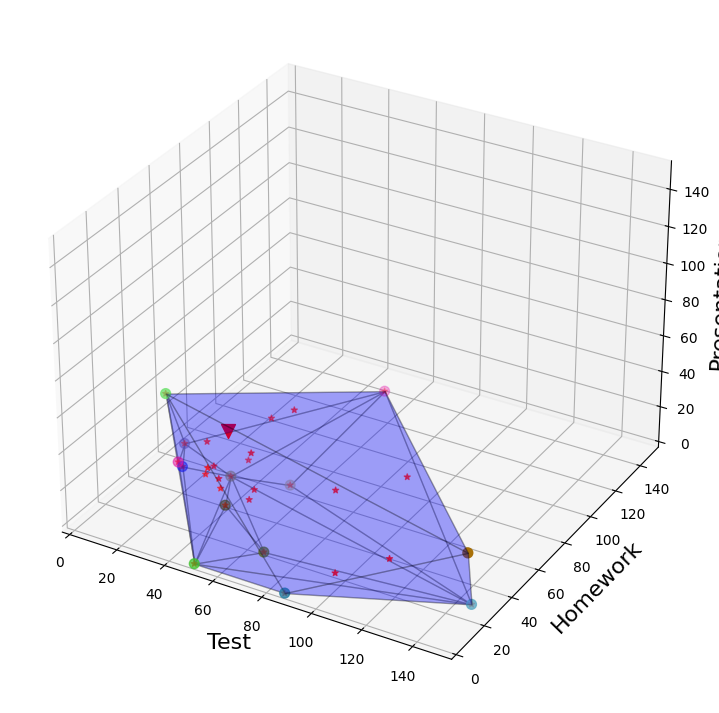

In [20]:
from mpl_toolkits.mplot3d import Axes3D
#from hull3D import ConvexHull3D
import numpy as np

pts = profs_pts

# Showing default parameters
Hull = ConvexHull3D(pts, run=True, preproc=False, make_frames=True, frames_dir='../output/frames/')

# To get Vertex objects:
vertices = Hull.DCEL.vertexDict.values()

# To get indices:
pts = Hull.getPts()    # to get pts in order used by ConvexHull3d
hull_vertices = pts[Hull.getVertexIndices()]

# To get vertices of each Face:
faces = [[list(v.p()) for v in face.loopOuterVertices()] for face in Hull.DCEL.faceDict.values()]

Hull.generateImage(newPt=user_data,show=True,profs_w=profs_weight)

# 교수자별 scatter plot 생성

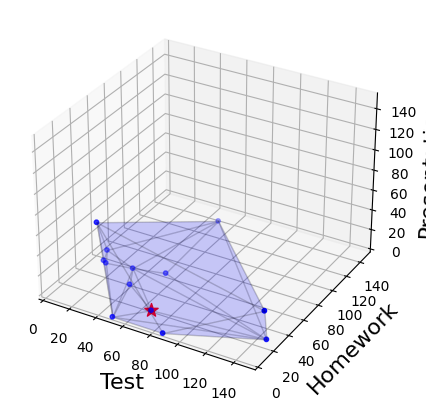

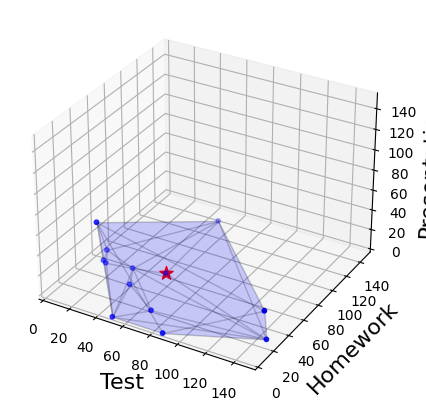

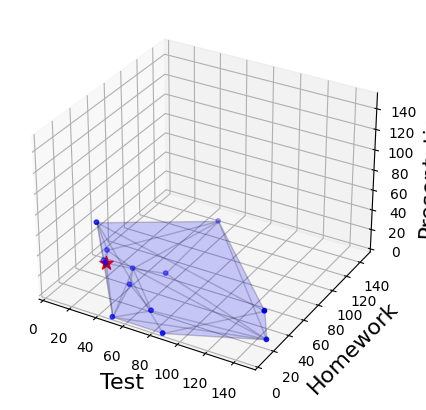

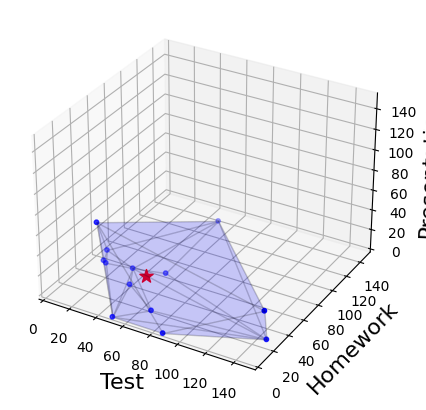

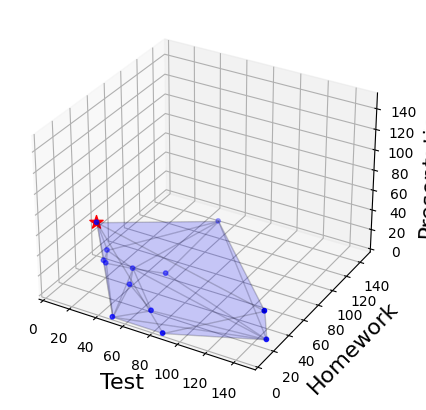

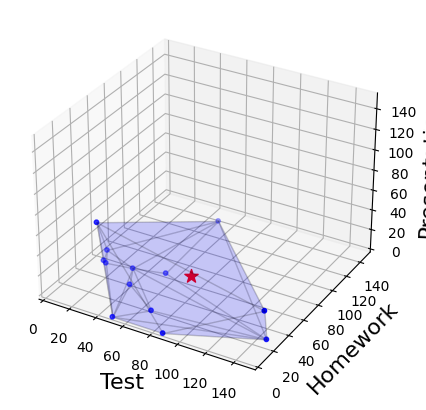

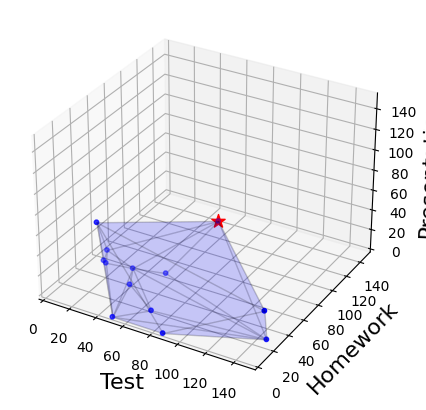

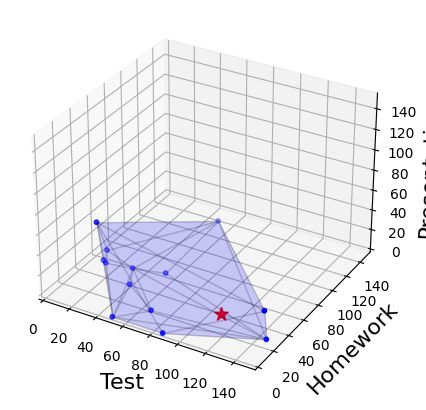

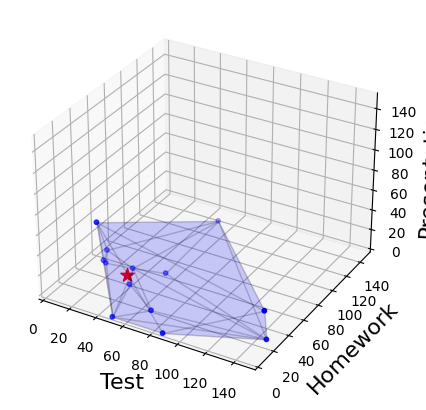

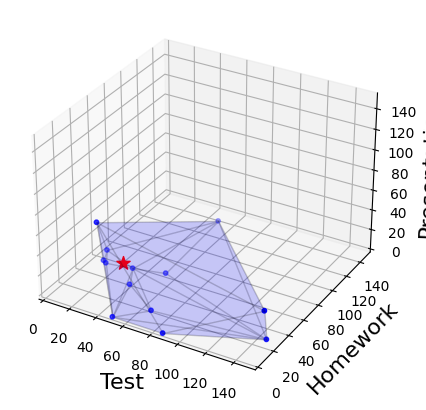

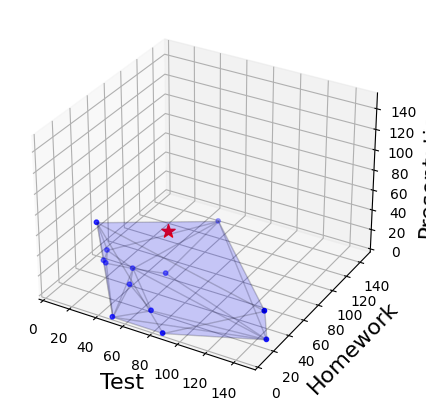

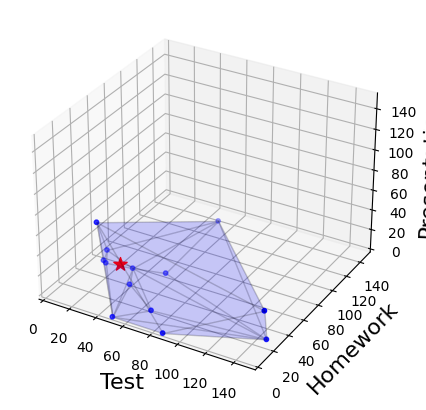

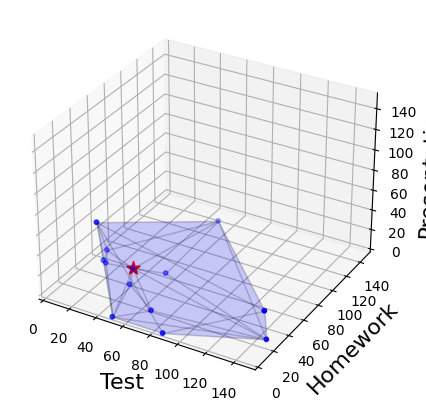

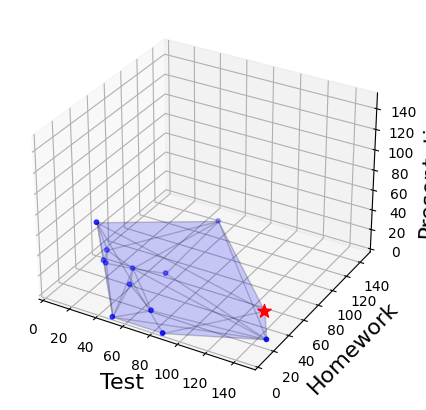

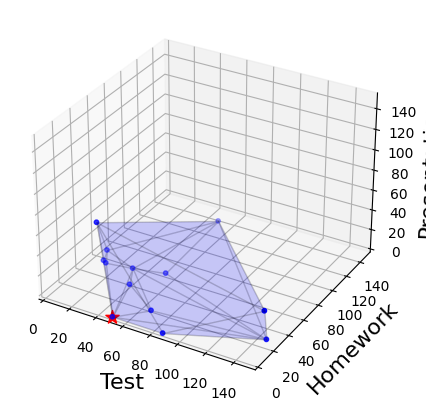

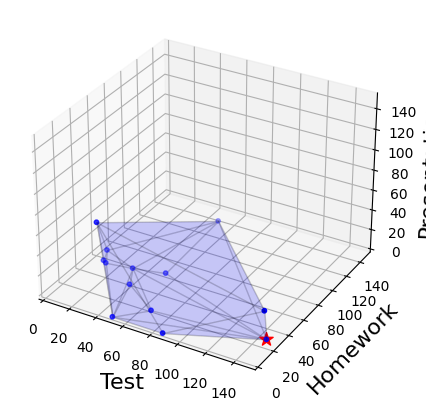

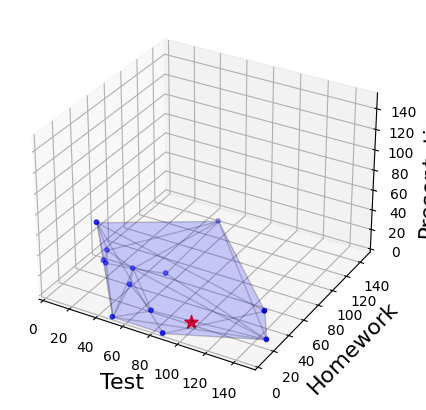

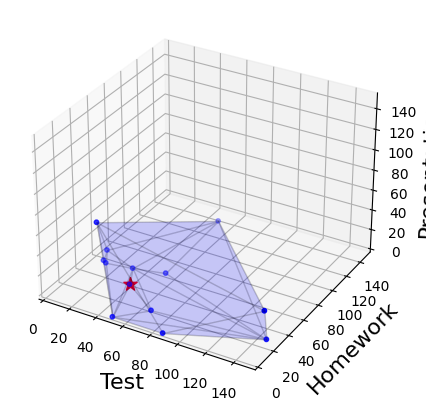

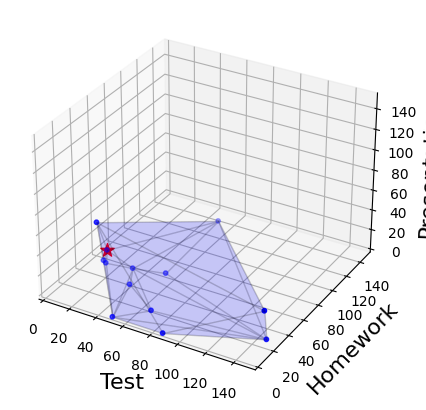

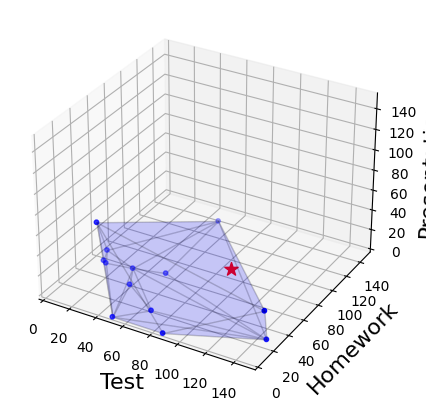

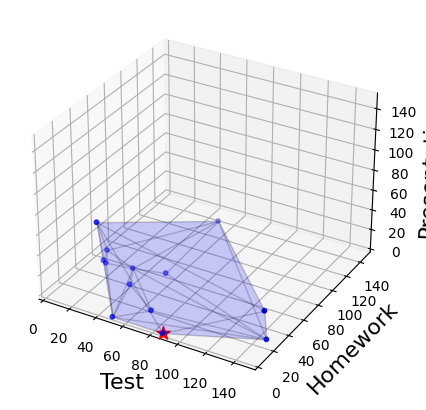

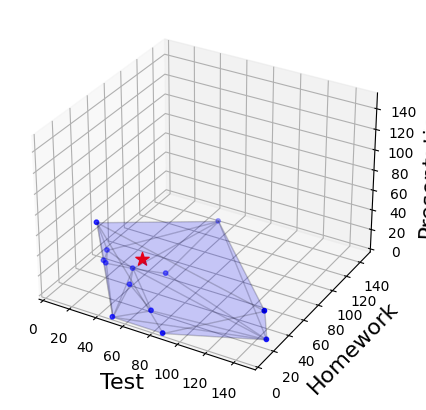

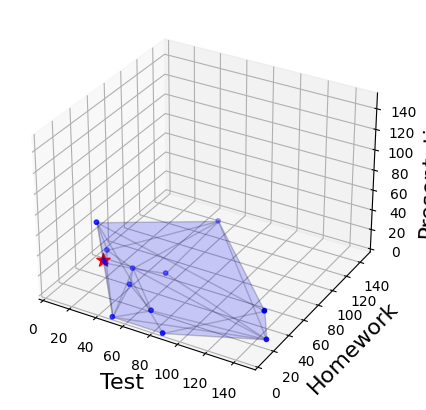

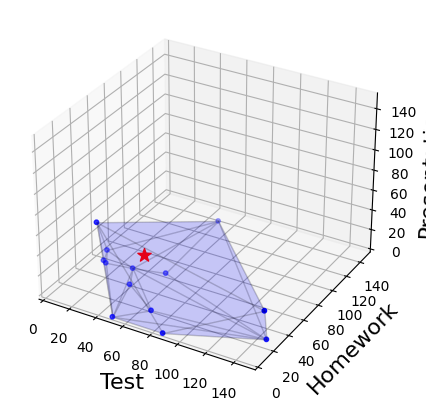

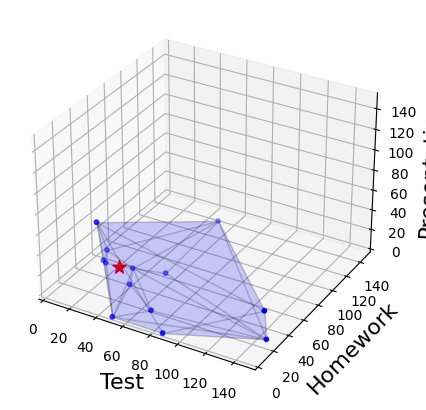

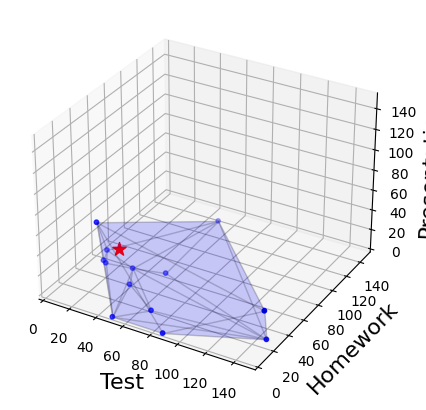

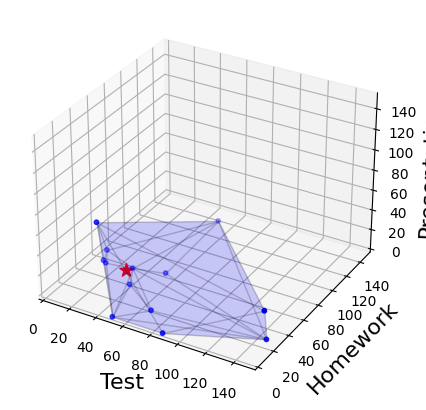

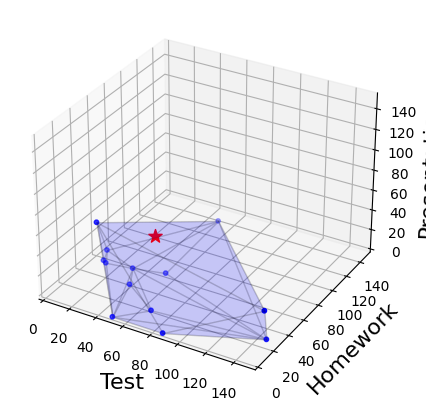

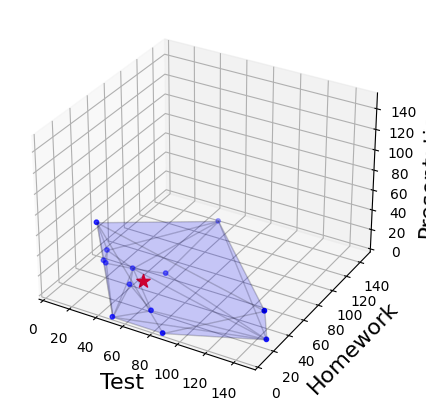

In [22]:
#print(profs_weight)
frames_dir='../output/scatters/'
for prof in profs_weight.keys():
    #print(prof)
    fig=plt.figure(figsize=(9,5))
    ax=plt.axes(projection='3d')

    ax.set_xlim([Hull.boxmin,Hull.boxmax])
    ax.set_ylim([Hull.boxmin,Hull.boxmax])
    ax.set_zlim([Hull.boxmin,Hull.boxmax])

    ax.set_xlabel('Test',fontsize=16)
    ax.set_ylabel('Homework',fontsize=16)
    ax.set_zlabel('Presentation',fontsize=16)

    vertices=array([list(v.p()) for v in Hull.DCEL.vertexDict.values()])
    ax.scatter(vertices[:,0],vertices[:,1],vertices[:,2],s=10,c='b',marker='o')
    alpha=0.1
    for face in Hull.DCEL.faceDict.values():
        tri = mpl3D.art3d.Poly3DCollection([[list(v.p()) for v in face.loopOuterVertices()]])
        tri.set_facecolor((0,0,1, 0.1)) # add functionality for visible faces later
        #tri.set_alpha(0.1)
        tri.set_edgecolor((0,0,0, 0.1))
        ax.add_collection3d(tri)

    ax.scatter(profs_weight[prof][0],profs_weight[prof][1],profs_weight[prof][2],s=100,c='r',marker='*')

    plt.savefig(frames_dir+prof+'.png')
    plt.show()

# profs.json 생성
## {교수자 이름, x좌표, y좌표, z좌표, 최대거리교수자, 최대거리, 최소거리교수자, 최소거리}

In [23]:
import json
from collections import OrderedDict

profs_distance={}

for i in profs_weight.keys():
    min_d=10000
    max_d=0
    profs_distance[i]={"max_prof":'',"max_d":0,"min_prof":'',"min_d":0,'x':profs_weight[i][0],
                        'y':profs_weight[i][1],'z':profs_weight[i][2]}
    for j in profs_weight.keys():
        if j!=i:
            tmp=distance(profs_weight[i],profs_weight[j])
            if tmp<min_d:
                min_d=tmp
                profs_distance[i]['min_d']=tmp
                profs_distance[i]['min_prof']=j
            if tmp>max_d:
                max_d=tmp
                profs_distance[i]['max_d']=tmp
                profs_distance[i]['max_prof']=j
    #print(i,profs_distance[i])

file_data=OrderedDict()
for prof in profs_distance.keys():
    file_data[prof]=profs_distance[prof]

with open('../output/jsons/profs.json','w',encoding='utf-8') as make_file:
    json.dump(file_data, make_file, ensure_ascii=False, indent="\t")

# Convex Hull 생성 과정 mp4

In [24]:
import cv2

image_folder='../output/frames'
video_name='../output/videos/output.mp4'

images=[img for img in os.listdir(image_folder) if img.endswith(".png")]
frame=cv2.imread(os.path.join(image_folder,images[0]))
height, width, layers = frame.shape

video=cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
    
cv2.destroyAllWindows()
video.release()

# Interactive Convex Hull

In [25]:
!pip install PyQt5

In [26]:
def Interactive(hull,newPt=None, profs_weight=None):
    %matplotlib qt
    ifig = plt.figure(figsize=(9, 6))
    iax = plt.axes(projection='3d')
    
    iax.set_xlim([hull.boxmin,hull.boxmax])
    iax.set_ylim([hull.boxmin,hull.boxmax])
    iax.set_zlim([hull.boxmin,hull.boxmax])
    
    iax.set_xlabel('Test')
    iax.set_ylabel('Homework')
    iax.set_zlabel('Presentation')

    iax.set_title("3D scatterplot", pad=25, size=15)
    
    vertices = array([list(v.p()) for v in hull.DCEL.vertexDict.values()])
    
    x=[]
    y=[]
    z=[]
    for profs in profs_weight.keys():
        x.append(profs_weight[profs][0])
        y.append(profs_weight[profs][1])
        z.append(profs_weight[profs][2])
        
    iax.scatter3D(x,y,z,s=20,c='r',marker='*')
        
    iax.scatter3D(vertices[:,0], vertices[:,1], vertices[:,2], s=50, c=np.random.rand(len(vertices),3), marker='o')

    alpha = 0.1
    for face in hull.DCEL.faceDict.values():
        tri = mpl3D.art3d.Poly3DCollection([[list(v.p()) for v in face.loopOuterVertices()]])
        tri.set_facecolor((0,0,1, 0.2)) # add functionality for visible faces later
        #tri.set_alpha(0.1)
        tri.set_edgecolor((0,0,0, 0.2))
        iax.add_collection3d(tri)
    
    if newPt is not None:
            iax.scatter(newPt[0],newPt[1],newPt[2],s=100,c='r',marker='v')

In [27]:
Interactive(Hull,newPt=user_data, profs_weight=profs_weight)